# Text-to-SQL Chain with Query Examples and Table Descriptions with Multi-Modality Capability
### DB: AWS S3
### SQL: AWS Athena
### Chat History Storage: AWS DynamoDB
### LLM: GPT-4

## Chain:

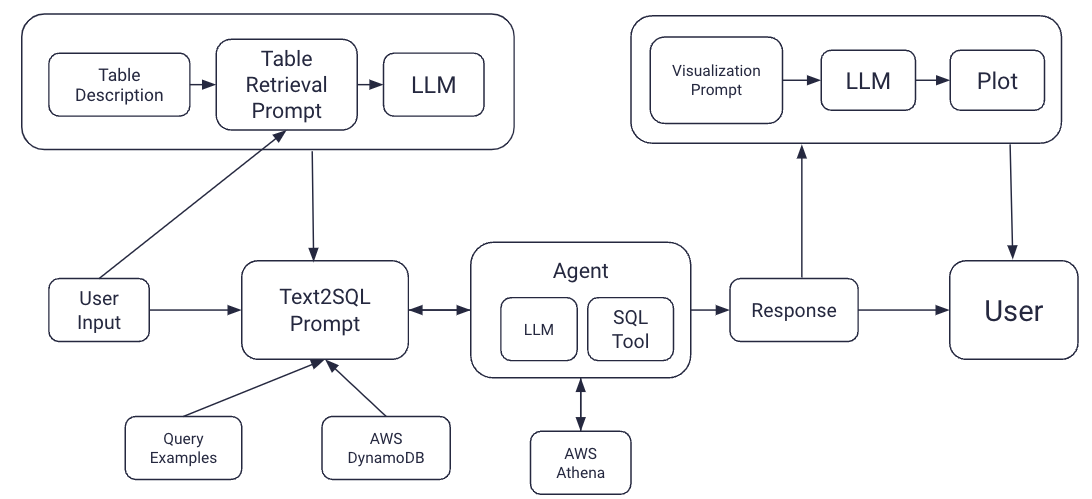

In [1]:
import getpass
import os
import json
import boto3

from typing import List

import pandas as pd
import matplotlib.pyplot as plt

import openai
from langchain.globals import set_debug
from langchain_openai import ChatOpenAI
from langchain.output_parsers.json import SimpleJsonOutputParser
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.chat_message_histories import (
    DynamoDBChatMessageHistory,
)
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents import tool
from langchain.agents import AgentExecutor

from sqlalchemy import create_engine
from urllib.parse import quote_plus

#set environmental variable for OpenAI API key
os.environ["OPENAI_API_KEY"] = getpass.getpass()

#### set up AWS S3 and Athena for Database Access

In [2]:
def load_db():
    #database info
    AWS_REGION = "us-east-1"
    SCHEMA_NAME = "wnba_db"
    S3_STAGING_DIR = "s3://wnbadata/"
    
    connect_str = "awsathena+rest://athena.{region_name}.amazonaws.com:443/{schema_name}?s3_staging_dir={s3_staging_dir}"
    
    #connect to AWS athena
    engine = create_engine(connect_str.format(
            region_name=AWS_REGION,
            schema_name=SCHEMA_NAME,
            s3_staging_dir=quote_plus(S3_STAGING_DIR)
    ))
    
    #create SQL db object
    return SQLDatabase(engine)

In [3]:
#create a Pydantic Base Model
class Table(BaseModel):
    """Table in SQL database."""
    name: str = Field(description = "Name of table in SQL database.")

#create table chain
class TableChain:
    def __init__(self, model_name):
        self.model_name = model_name
        self.table_chain = self.create_table_chain()

    def get_table_details(self):
        file_paths = [
            "src/wnba_nba_pbp_data_dict.json",
            "src/wnba_player_box.json",
            "src/wnba_player_info.json",
            "src/wnba_schedule.json",
            "src/wnba_teambox.json"
        ]
        
        table_details = ""
    
        for file_path in file_paths:
            
            #load table names and descriptions from json
            f = open(file_path)
            table_dict = json.load(f)
            
            #retrieve table names and descriptions and compile into string
            table_details = table_details + "Table Name:" + table_dict['table_name'] + "\n" \
            + "Table Description:" + table_dict['table_description']
    
            for col in table_dict['values']:
                table_details = table_details + "\n" + "Column Name:" + col['column_name'] + "\n" \
                + "Column Description:" + col['column_description'] + "\n" \
                + "COlumn Type:" + col['column_type']
            
            table_details = table_details + "\n\n"
        
        return table_details

    def create_table_chain(self):
        
        table_details = self.get_table_details()
        
        #create table chain prompt
        table_prompt_system = f"""Refer the Above Context and Return the names of SQL Tables that MIGHT be relevant to the above context\n\n 
        The tables are:
        
        {table_details}
         """
        
        table_details_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", table_prompt_system),
                ("human", "{input}"),
            ]
        )
        
        #set up LLM
        if "claude" in self.model_name:
            table_chain_llm = ChatAnthropic(model = self.model_name, temperature = 0)
        else:
            table_chain_llm = ChatOpenAI(model_name = self.model_name, temperature = 0)
        table_chain_llm_wtools = table_chain_llm.bind_tools([Table])
        output_parser = PydanticToolsParser(tools=[Table])

        #create table chain
        table_chain = table_details_prompt | table_chain_llm_wtools | output_parser

        return table_chain

    def invoke(self, query):
        return self.table_chain.invoke(query)

In [4]:
#create visulization chain
class VisualizationChain:
    def __init__(self, model_name):
        self.model_name = model_name
        self.visualization_chain = self.create_visualization_chain()

    def create_visualization_chain(self):
        json_parser = SimpleJsonOutputParser()
        #set up LLM
        vis_llm = ChatOpenAI(model_name = self.model_name, temperature = 0)
        vis_chain = vis_llm | json_parser
        return vis_chain

    def invoke(self, query):
        vis_prompt = (
            """
            You are a data visualization expert.
            Determine which of table, bar chart, line chart, or no chart required is the most suitable for visualizating the following context.
            
            If it requires drawing a table, reply as follows:
            {"table": {"columns": ["column1", "column2", ...], "data": [[value1, value2, ...], [value1, value2, ...], ...]}}
            
            If the query requires creating a bar chart, reply as follows:
            {"bar": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}
            
            If the query requires creating a line chart, reply as follows:
            {"line": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}
            
            There can only be two types of chart, "bar" and "line".
            
            If you think neither is suitable or itt requires neither, reply as follows:
            {"answer": "I do not know."}
            
            Return all output as a string.
            
            All strings in "columns" list and data list, should be in double quotes,
            
            For example: {"columns": ["title", "ratings_count"], "data": [["Gilead", 361], ["Spider's Web", 5164]]}
            
            Lets think step by step.
            
            Below is the context.
            Context:
            """
            + str(query)
        )
        
        response = self.visualization_chain.invoke(vis_prompt)
        self.plot(response)
        
    def plot(self, response_dict):
        # Check if the response is an answer.
        if "answer" in response_dict:
            return    
        try:
            # Check if the response is a bar chart.
            if "bar" in response_dict:
                data = response_dict["bar"]
                df = pd.DataFrame.from_dict(data)
                plt.bar(df["columns"].values, df["data"].values)
                plt.xticks(rotation = 315)
                plt.show()
        
            # Check if the response is a line chart.
            elif "line" in response_dict:
                data = response_dict["line"]
                df = pd.DataFrame.from_dict(data)
                plt.plot(df["columns"].values, df["data"].values)
                plt.xticks(rotation = 315)
                plt.show()
        
            # Check if the response is a table.
            elif "table" in response_dict:
                data = response_dict["table"]
                df = pd.DataFrame(data["data"], columns = data["columns"])
                plt.table(cellText = df.values, colLabels = df.columns, loc='center')
                plt.axis("off")
                plt.show()
        except ValueError as e:
            return
            

In [5]:
#create text2sql chain
class QAEngine:
    def __init__(self, model_name, db, session_id, user_id):
        self.model_name = model_name
        self.db = db
        self.chat_history = None
        self.load_chat_history(session_id, user_id)
        self.query_examples = self.load_query_examples()
        self.table_chain = TableChain(model_name)
        self.visualization_chain = VisualizationChain(model_name)
        self.text_sql_agent, self.sql_tools = self.create_text_sql_agent()

    def update_db(self, db):
        self.db = db

    def load_chat_history(self, session_id, user_id):
        #set up dynamodb
        dynamodb = boto3.resource("dynamodb")
        
        sessionid = f"session_id::{session_id}"
        userid = f"{user_id:04}"
        
        #create composite key (session id & user id) for accessing databases
        composite_key = {
            "SessionId": sessionid,
            "UserID": userid,
        }
        
        #query DynamoDB for chat history using the composite key
        chat_history = DynamoDBChatMessageHistory(
            table_name = "Chat_Table",
            session_id = "0",
            key = composite_key,
            history_size = 6,
        )

        self.chat_history = chat_history

    def load_query_examples(self):
        #load query examples from json
        f = open("src/query_example.json")
        query_examples_json = json.load(f)
        
        return query_examples_json["query_examples"]

    def create_text_sql_agent(self):
        #set up LLM
        if "claude" in self.model_name:
            llm = ChatAnthropic(model = self.model_name, temperature = 0)
        else:
            llm = ChatOpenAI(model_name = self.model_name, temperature= 0)
        #utilize langchain agent toolkit: SQL toolkit
        toolkit = SQLDatabaseToolkit(db = self.db, llm = llm)
        tools = toolkit.get_tools()
        llm_with_tools = llm.bind_tools(tools)
        
        #create few shot prompt with query examples
        example_prompt = ChatPromptTemplate.from_messages(["User input: {input}\nSQL query: {query}"])
        few_shot_prompt = FewShotChatMessagePromptTemplate(
            examples = self.query_examples,
            example_prompt = example_prompt,
        )
        
        #create prompt for agent
        prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                """You are an agent designed to interact with a SQL database and a WNBA expert to answer questions about the WNBA.
                Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
                If applicable, return the statistical numbers as well.
                You should also leverage your pre-existing knowledge of WNBA rules, statistics, teams, players, and history to understand and interpret user questions and your answer accurately.
                Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
                You can order the results by a relevant column to return the most interesting examples in the database.
                Never query for all the columns from a specific table, only ask for the relevant columns given the question.
                You have access to tools for interacting with the database.
                Base your final answer on the information returned by these tools, combined with your existing knowledge of the WNBA.
                You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
        
                When referring to a specific game, DO NOT just provide the game ID. You MUST also provide the two teams involved in the game.
                
                DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
        
                DO NOT give me the SQL query.
                
                You MUST always execute the query and use the result to contruct the final answer.
                
                To start you should ALWAYS look at the tables in the database to see what you can query.
                Do NOT skip this step.
                Then you should query the schema of the most relevant tables.
                Here is the relevant table info, but feel free to use other tables you deem necessary: {table_names_to_use}.""",
            ),
            few_shot_prompt,
            MessagesPlaceholder(variable_name = "chat_history"),
            ("user", "{input}"),
            #message placeholder for storing intermediate steps
            MessagesPlaceholder(variable_name = "agent_scratchpad"),
        ])

        #create agent
        agent = (
            {
                "input": lambda x: x["input"],
                "agent_scratchpad": lambda x: format_to_openai_tool_messages(
                    x["intermediate_steps"]
                ),
                "chat_history": lambda x: x["chat_history"],
                "table_names_to_use": lambda x: x["table_names_to_use"],
            }
            | prompt
            | llm_with_tools
            | OpenAIToolsAgentOutputParser()
        )
        
        return agent, tools

    def invoke(self, query):
        response = None
        max_iteration = 10
        error_count = 0
        count = 0
        agent_executor = AgentExecutor(agent = self.text_sql_agent, tools = self.sql_tools, verbose = False, return_intermediate_steps = True, max_iterations = max_iteration)
        while response is None and count <= 5:
            try:
                response = agent_executor.invoke({
                    "input": query,
                    "chat_history": self.chat_history.messages,
                    #passing result of table chain to text2sql agent
                    "table_names_to_use": self.table_chain.invoke(query)
                })
            except (openai.BadRequestError, openai.APIError, anthropic.APIStatusError) as e:
                if error_count == 0:
                    max_iteration = 5
                elif error_count == 1:
                    max_iteration = 1
                agent_executor = AgentExecutor(agent = self.text_sql_agent, tools = self.sql_tools, verbose = False, return_intermediate_steps = True, max_iterations = max_iteration)
                error_count += 1
                count += 1
            except Exception as e:
                if response is not None and ('SQL query' in response['output'] or 'Agent stopped' in response['output']):
                    response = None
                    count += 1 
            else:
                if 'SQL query' in response['output'] or 'Agent stopped' in response['output']:
                    response = None
                    count += 1
                    
        if response is not None:
            self.chat_history.add_user_message(query)
            self.chat_history.add_ai_message(response["output"])
            self.visualization_chain.invoke(response["output"])
            return response['output']
        else:
            self.chat_history.add_user_message(query)
            self.chat_history.add_ai_message("no response")
            return "no response"

In [6]:
awsdb = load_db()
gpt4T_text2sql = QAEngine("gpt-4-turbo", awsdb, 203, 1)

/var/folders/1c/ybx_8cds1ybgdg3z19ptmmk00000gn/T/ipykernel_91550/3112801148.py:10: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pyathena.sqlalchemy.rest.AthenaRestDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(connect_str.format(


>>>  Which player scored the most points in a single game between 2018 and 2024?


loading response....
Response: The player who scored the most points in a single game between 2018 and 2024 is Liz Cambage, with a record of 53 points in one game.


>>>  Which players scored the most points in a single game between 2018 and 2024?


loading response....


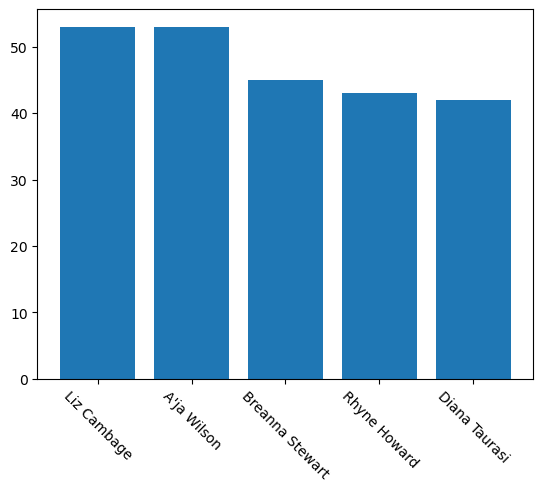

Response: The players who scored the most points in a single game between 2018 and 2024 are:

1. Liz Cambage - 53 points
2. A'ja Wilson - 53 points
3. Breanna Stewart - 45 points
4. Rhyne Howard - 43 points
5. Diana Taurasi - 42 points


>>>  Which team had the highest average points per game in the 2021 season?


loading response....
Response: The team with the highest average points per game in the 2021 WNBA season was the Las Vegas Aces, with an average of 89.25 points per game.


>>>  Which teams had the highest average points per game in the 2021 season?


loading response....


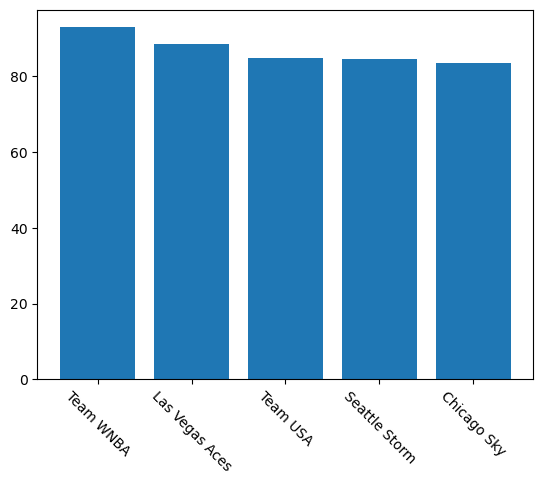

Response: The teams with the highest average points per game in the 2021 WNBA season were:

1. Team WNBA - 93.0 points per game
2. Las Vegas Aces - 88.65 points per game
3. Team USA - 85.0 points per game
4. Seattle Storm - 84.5 points per game
5. Chicago Sky - 83.6 points per game


>>>  How many games ended in overtime during the 2023 season?


loading response....
Response: During the 2023 WNBA season, 11 games ended in overtime.


>>>  Which player had the highest free throw percentage in the 2020 season (min. 25 FT’s attempted)?


loading response....


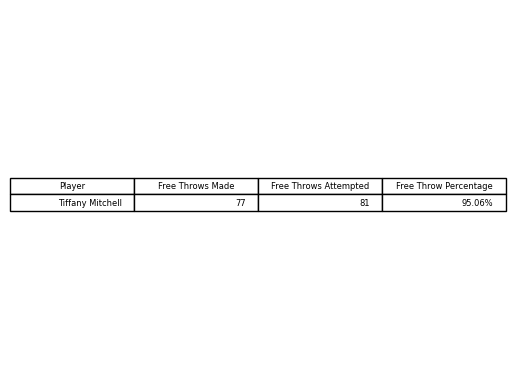

Response: In the 2020 WNBA season, Tiffany Mitchell had the highest free throw percentage among players with at least 25 free throws attempted. She made 77 out of 81 free throws, achieving a free throw percentage of approximately 95.06%.


>>>  Which players had the highest free throw percentage in the 2020 season (min. 25 FT’s attempted)?


loading response....


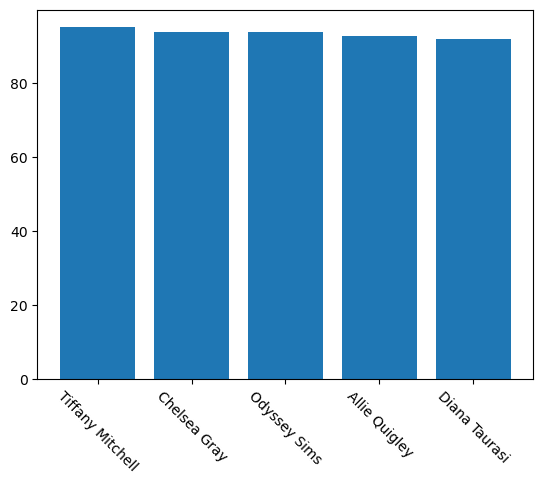

Response: The players with the highest free throw percentages in the 2020 WNBA season, with a minimum of 25 free throws attempted, were:

1. Tiffany Mitchell - 95.06% (77 made out of 81 attempted)
2. Chelsea Gray - 93.88% (46 made out of 49 attempted)
3. Odyssey Sims - 93.88% (46 made out of 49 attempted)
4. Allie Quigley - 92.68% (38 made out of 41 attempted)
5. Diana Taurasi - 91.80% (112 made out of 122 attempted)


>>>  What was the win-loss record of the Seattle Storm in the 2022 season?


loading response....


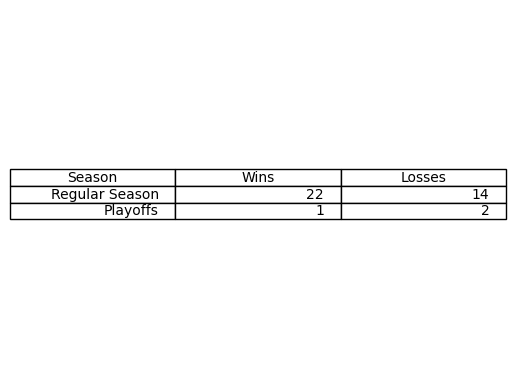

Response: In the 2022 WNBA season, the Seattle Storm had the following win-loss records:

- Regular Season: 22 wins and 14 losses
- Playoffs: 1 win and 2 losses


>>>  What was the win-loss record of each team in the 2022 season?


loading response....


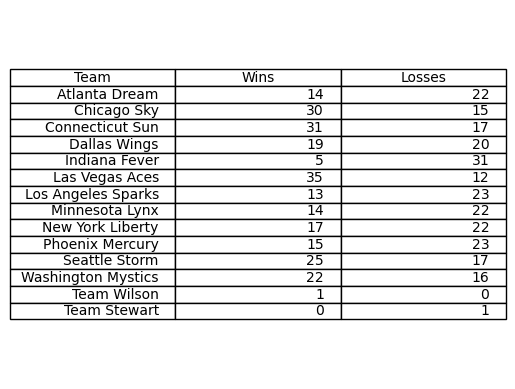

Response: In the 2022 WNBA season, the win-loss records for each team were as follows:

- Atlanta Dream: 14 wins, 22 losses
- Chicago Sky: 30 wins, 15 losses
- Connecticut Sun: 31 wins, 17 losses
- Dallas Wings: 19 wins, 20 losses
- Indiana Fever: 5 wins, 31 losses
- Las Vegas Aces: 35 wins, 12 losses
- Los Angeles Sparks: 13 wins, 23 losses
- Minnesota Lynx: 14 wins, 22 losses
- New York Liberty: 17 wins, 22 losses
- Phoenix Mercury: 15 wins, 23 losses
- Seattle Storm: 25 wins, 17 losses
- Washington Mystics: 22 wins, 16 losses

Additionally, there were two special teams for an event:
- Team Wilson: 1 win, 0 losses
- Team Stewart: 0 wins, 1 loss


>>>  Which team had the longest winning streak in the 2019 season (inclusive of postseason)?


loading response....
Response: In the 2019 WNBA season, the team with the longest winning streak, including the postseason, was the Washington Mystics with a streak of 32 consecutive wins.


>>>  How many triple-doubles were recorded in the WNBA between 2018 and 2024, and who had the most triple-doubles?


loading response....


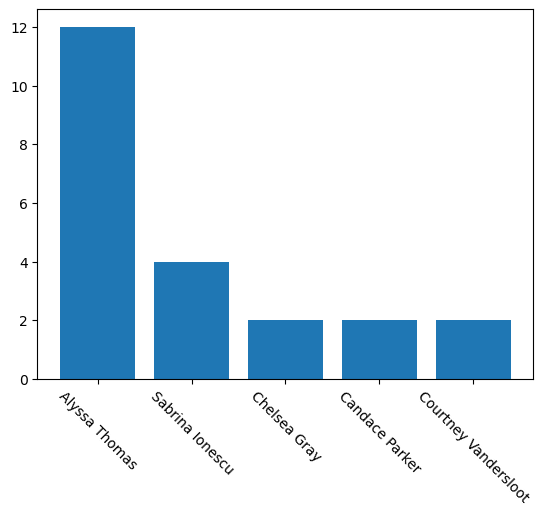

Response: Between 2018 and 2024, there were a total of 22 triple-doubles recorded in the WNBA. Alyssa Thomas had the most triple-doubles during this period, with a total of 12. Other notable players include Sabrina Ionescu with 4 triple-doubles, and Chelsea Gray, Candace Parker, and Courtney Vandersloot each with 2 triple-doubles.


>>>  Which team had the best defense in the 2024 season (by opponent points)?


loading response....
Response: The team with the best defense in the 2024 WNBA season, based on the lowest average opponent points per game, was the Connecticut Sun. They allowed an average of 71.08 points per game to their opponents.


>>>  Identify the game with the highest combined score (both teams) from 2018 to 2024.


loading response....
Response: The game with the highest combined score between 2018 and 2024 was between Team Stewart and Team Wilson, with a total score of 270 points. The game ID for this match is 401558893.


>>>  Which player played the most minutes in the 2021 season?


loading response....


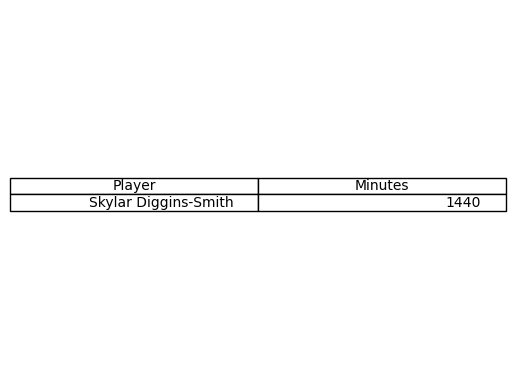

Response: The player who played the most minutes in the 2021 WNBA season was Skylar Diggins-Smith, with a total of 1,440 minutes.


>>>  What is the average attendance for games in the 2020 season?


loading response....
Response: The average attendance for WNBA games during the 2020 season was 0. This was due to the COVID-19 pandemic, which led to games being played without fans in attendance.


>>>  bye


In [7]:
input_text = input('>>> ')
while input_text.lower() != 'bye':
    if input_text:
        
        print("loading response....")
        
        response = gpt4T_text2sql.invoke(input_text)

        print("Response: " + response)
    input_text = input('>>> ')